# Charuco Camera Calibration

##### Imports

In [10]:
import cv2
import cv2.aruco as aruco
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from PIL import Image
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# ------------------------------
ARUCO_DICT = cv2.aruco.DICT_6X6_250
SQUARES_VERTICALLY = 5
SQUARES_HORIZONTALLY = 7
SQUARE_LENGTH = 0.04
MARKER_LENGTH = 0.03

dictionary = cv2.aruco.getPredefinedDictionary(ARUCO_DICT)
board = cv2.aruco.CharucoBoard((SQUARES_VERTICALLY, SQUARES_HORIZONTALLY), SQUARE_LENGTH, MARKER_LENGTH, dictionary)
params = cv2.aruco.DetectorParameters()
# ------------------------------

image_files = glob.glob('./images/charuco_exp/*.jpg')

##### Helper functions

In [44]:
def load_image(image_path, resize=True):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if resize:
        image = cv2.resize(image, (image.shape[1]//4, image.shape[0]//4))
    return image

def decompose_image(image):
    marker_corners, marker_ids, _ = aruco.detectMarkers(image, dictionary, parameters=params)
    charuco_retval, charuco_corners, charuco_ids = aruco.interpolateCornersCharuco(marker_corners, marker_ids, image, board)
    if charuco_retval:
        return charuco_corners, charuco_ids, marker_corners, marker_ids
    return None, None, None, None

def compute_instrinsic(images, resize=True):
    '''
    Function to compute the K matrix from a directory of images
    Outputs:
    - K: camera matrix
    - df: dataframe containing marker and charuco coordinates and ids for each image
    '''
    charuco_corners_all = []
    charuco_id_all = []
    df = pd.DataFrame()
    
    for i, image_path in enumerate(images):
        image = load_image(image_path, resize=resize)
        c_corners, c_ids, m_corners, m_ids = decompose_image(image)
        
        if c_corners is not None:
            charuco_corners_all.append(c_corners)
            charuco_id_all.append(c_ids)
            
            df = pd.concat([
                df,
                pd.DataFrame({
                    'image_path': image_path,
                    'marker_id': [m_ids.squeeze()],
                    'charuco_id': [c_ids.squeeze()],
                    'marker_corners': [np.array(m_corners).squeeze()],
                    'charuco_corners': [c_corners.squeeze()]
                }, index=[i])
            ])
    
    retval, K, dist_coeffs, _, _ = aruco.calibrateCameraCharuco(
        charuco_corners_all, charuco_id_all, board, image.shape[:2], None, None
    )
    
    if retval:
        return K, dist_coeffs, df
    
def compute_P(K, R, t):
    Rt = np.hstack((R,t))
    return K @ Rt

def compute_origin_px(X_w, C, R, K):
    C = np.reshape(C, (3,1))
    X_c = R @ (X_w - C)

    m_x = X_c[0] / X_c[2]
    m_y = X_c[1] / X_c[2]

    u = K[0, 0] * m_x + K[0, 2]
    v = K[1, 1] * m_y + K[1, 2]

    return (int(u[0]), int(v[0]))

def plot_image_plane(K, R, t, img_width=5536, img_height=4160):
    fx, fy = K[0, 0], K[1, 1]
    cx, cy = K[0, 2], K[1, 2]
    
    z_plane = fx
    
    corners = np.array([
        [-(cx / fx) * z_plane, -(cy / fy) * z_plane, z_plane], 
        [(img_width - cx) / fx * z_plane, -(cy / fy) * z_plane, z_plane], 
        [(img_width - cx) / fx * z_plane, (img_height - cy) / fy * z_plane, z_plane],  
        [-(cx / fx) * z_plane, (img_height - cy) / fy * z_plane, z_plane]
    ], dtype=np.float64)
    
    t = t.reshape(3, 1)  
    corners_world = (R.T @ corners.T + t).T  
    
    C = -R.T @ t
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    img_plane = Poly3DCollection([corners_world], alpha=0.5, color='blue')
    ax.add_collection3d(img_plane)
    
    ax.scatter(*C.flatten(), color='red', label="Camera Center")
    
    for corner in corners_world:
        ax.plot([C[0, 0], corner[0]], [C[1, 0], corner[1]], [C[2, 0], corner[2]], 'k--')
    
    # Set plot limits and labels
    ax.set_xlim([-2, 2])
    ax.set_ylim([-2, 2])
    ax.set_zlim([-2, 2])
    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")
    ax.set_zlabel("Z-axis")
    ax.legend()
    plt.show()

##### Single Image Decomposition

In [12]:
# K, dist_coeffs, df = compute_instrinsic(image_files, resize=False)
K = np.array([[9.15174127e+03, 0.00000000e+00, 2.42775362e+03],
       [0.00000000e+00, 9.10725194e+03, 2.15567590e+03],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])
dist_coeffs = np.array([[-9.91043732e-02, -1.59405374e-02,  1.91785932e-03, -8.15007677e-03,  1.37990032e+01]])

Projection matrix P:
 [[ 7.64810215e+03 -3.17912202e+03  4.58781784e+03  1.67223771e+03]
 [ 4.58227702e+03  8.11320905e+03 -8.76100872e+02  5.78640838e+01]
 [-6.42623604e-02  4.00687747e-01  9.13958248e-01  7.16213905e-01]] 

Camera matrix K:
 [[9.15174127e+03 0.00000000e+00 2.42775362e+03]
 [0.00000000e+00 9.10725194e+03 2.15567590e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] 

Rotation matrix R:
 [[ 0.8527465  -0.45367248  0.25885264]
 [ 0.51835679  0.79600918 -0.31253101]
 [-0.06426236  0.40068775  0.91395825]] 

Translation vector t:
 [[-0.00727219]
 [-0.16317337]
 [ 0.71621391]] 

Camera position:
 [[ 0.13680895]
 [-0.16038983]
 [-0.70370392]]


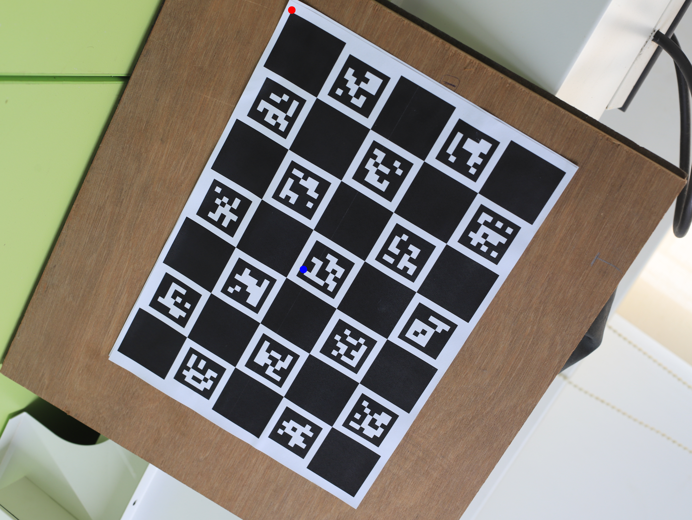

In [42]:
i = -1
image = load_image(image_files[i], resize=False)
charuco_corners, charuco_ids, marker_corners, marker_ids = decompose_image(image)

retval, rvec, tvec = cv2.aruco.estimatePoseCharucoBoard(charuco_corners, charuco_ids, board, K, dist_coeffs, None, None)

R, _ = cv2.Rodrigues(rvec)
P = compute_P(K, R, tvec)
C = -R.T @ tvec

cx, cy = K[0, -1], K[1, -1]

print("Projection matrix P:\n", P, '\n')
print("Camera matrix K:\n", K, '\n')
print("Rotation matrix R:\n", R, '\n')
print("Translation vector t:\n", tvec, '\n')
print("Camera position:\n", C)

computed_origin = compute_origin_px(
    np.array([[0,0,0]], dtype=np.float32),
    C, R, K
)

cv2.circle(image, computed_origin, 30, (255, 0, 0), -1)
cv2.circle(image, (int(cx), int(cy)), 30, (0, 0, 255), -1)

Image.fromarray(image).resize((image.shape[1]//8, image.shape[0]//8))

# aruco.drawDetectedMarkers(image, marker_corners, marker_ids)
# cv2.drawFrameAxes(image, K, dist_coeffs, rvec, tvec, length=0.1, thickness=40)
# Image.fromarray(image).resize((image.shape[1]//8, image.shape[0]//8))

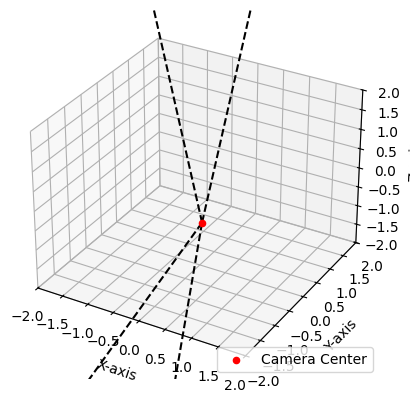

In [45]:
plot_image_plane(K, R, tvec, img_width=5536, img_height=4160)